In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MyProject

/content/drive/MyDrive/MyProject


In [3]:
#checking the present working directory
!pwd

/content/drive/MyDrive/MyProject


In [4]:
#checking GPU availability
import torch
torch.cuda.is_available()

True

In [5]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(n_gpu)
torch.cuda.get_device_name(0)


1


'Tesla V100-SXM2-16GB'

In [6]:
# install huggingface Transformers
! pip install transformers


     |████████████████████████████████| 2.1MB 12.2MB/s 
     |████████████████████████████████| 901kB 51.7MB/s 
     |████████████████████████████████| 3.3MB 67.8MB/s 


In [7]:
import transformers
print(transformers.__version__)

4.5.1


In [8]:
!pip install tqdm


In [9]:
from torch.utils.data import DataLoader, RandomSampler, random_split
from transformers import BertTokenizer, DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering, AdamW
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import json
from pathlib import Path
import os
import shutil
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline


In [ ]:
! pwd
%mkdir dataset

/content/drive/My Drive/MyProject
mkdir: cannot create directory ‘dataset’: File exists


##Finetuning BERT with SQUAD V2 Dataset##

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dataset/dev-v2.0.json

--2021-05-09 13:40:57--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘dataset/train-v2.0.json’

dataset/train-v2.0. 100%[===================>]  40.17M  97.5MB/s    in 0.4s    

2021-05-09 13:40:58 (97.5 MB/s) - ‘dataset/train-v2.0.json’ saved [42123633/42123633]

--2021-05-09 13:40:58--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dataset/dev-v2.0.jso

In [10]:
#function to read the train and dev (test) json data
#please open the JSON file to see what is teh format thats being used in the json file
#reading the data as per the format is important 

#Each split is in a structured json file with a number of questions and answers for each passage (or context). 

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers


In [11]:
#reading the train and dev json data

#The contexts and questions are just strings
#The answers are dicts containing the subsequence of the passage with the correct answer as well as an integer indicating the character at which the answer begins.

train_contexts, train_questions, train_answers = read_squad('dataset/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('dataset/dev-v2.0.json')

In [12]:
#Since we already have the starting position for the answers...we need the character position where the answer is ending in the passage(context)

def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)



In [13]:
#Converting into a dataframe

examples = pd.DataFrame(
    {'contexts': train_contexts,
     'questions': train_questions
    })
answers=pd.DataFrame(train_answers)

In [14]:
final_data=pd.concat([examples,answers],axis=1)
final_data.head()


,contexts,questions,text,answer_start,answer_end
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286


In [15]:
final_data.isnull().values.any() #checking if there is any null or nan values in our dataframe/dataset

False

In [16]:
#Tokenizing the context and questions pairs
#We need to send tokenized inputs to the model. 

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [17]:
tokenizer("What is your name? My name is Barry Allen", "What is your name?")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 2026, 2171, 2003, 6287, 5297, 102, 2054, 2003, 2115, 2171, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
#converting the character start/end positions to token start/end positions

def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [20]:
#creating Dataset Object of encodings


class DatasetObject(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = DatasetObject(train_encodings)
val_dataset = DatasetObject(val_encodings)   #keeping the validation dataset for testing/evaluating

In [21]:
train_loader = DataLoader(train_dataset, batch_size=16,shuffle=True)

In [22]:
%mkdir model/checkpoint

In [23]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/MyProject/model/checkpoint*-[0-9]*'))

In [24]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [25]:
distil_bert="distilbert-base-uncased"

if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/drive/MyDrive/MyProject/model/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = DistilBertForQuestionAnswering.from_pretrained(distil_bert)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = DistilBertForQuestionAnswering.from_pretrained(distil_bert)

model.to(device)
model.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [26]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0169,  0.0263,  0.0051,  ...,  0.0339, -0.0049, -0.0185],
        [ 0.0107, -0.0217,  0.0236,  ..., -0.0208,  0.0110, -0.0050]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [27]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters,lr=learning_rate, eps=adam_epsilon)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [28]:
for epoch in range(2):
  print("\n____________Epoch Number:{}_________________".format(epoch))
  # set model to train mode
  model.train()
  # setup loop (we use tqdm for the progress bar)
  #loop = tqdm(train_loader, leave=True)
  for batch in train_loader:
    # initialize calculated gradients (from prev step)
    optimizer.zero_grad()
    # pull all the tensor batches required for training
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)    
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    # train model on batch and return outputs (incl. loss)
    outputs = model(input_ids, attention_mask=attention_mask,
                      start_positions=start_positions,
                      end_positions=end_positions)

    loss = outputs[0]
    train_loss_set.append(loss)
    # calculate loss for every parameter that needs grad update
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    tr_loss += loss.item()
    #update parameters
    optimizer.step()
    #model.zero_grad()
    global_step += 1

    # print relevant info to progress bar
    # loop.set_description(f'Epoch {epoch}')
    # loop.set_postfix(loss=loss.item()
     
    if global_step % 1000 == 0:
      print("Train loss: {}".format(tr_loss/global_step))
      output_dir = '/content/drive/MyDrive/MyProject/model/checkpoint-{}'.format(global_step)
      if not os.path.exists(output_dir): 
        os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)


____________Epoch Number:0_________________
Train loss: 2.2844887598752974
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-1000
Train loss: 1.8812529257833959
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-2000
Train loss: 1.7168126158118249
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-3000
Train loss: 1.610316826827824
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-4000
Train loss: 1.5423058553636073
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-5000

____________Epoch Number:1_________________
Train loss: 1.4578580586786072
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-6000
Train loss: 1.3817688247710467
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-7000
Train loss: 1.3270944476202131
Saving model checkpoint to /content/drive/MyDrive/MyProject/model/checkpoint-8000
Train l

In [29]:
# #Saving the Model
output_dir = '/content/drive/MyDrive/MyProject/model/checkpoint-final/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [30]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/MyProject/model/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

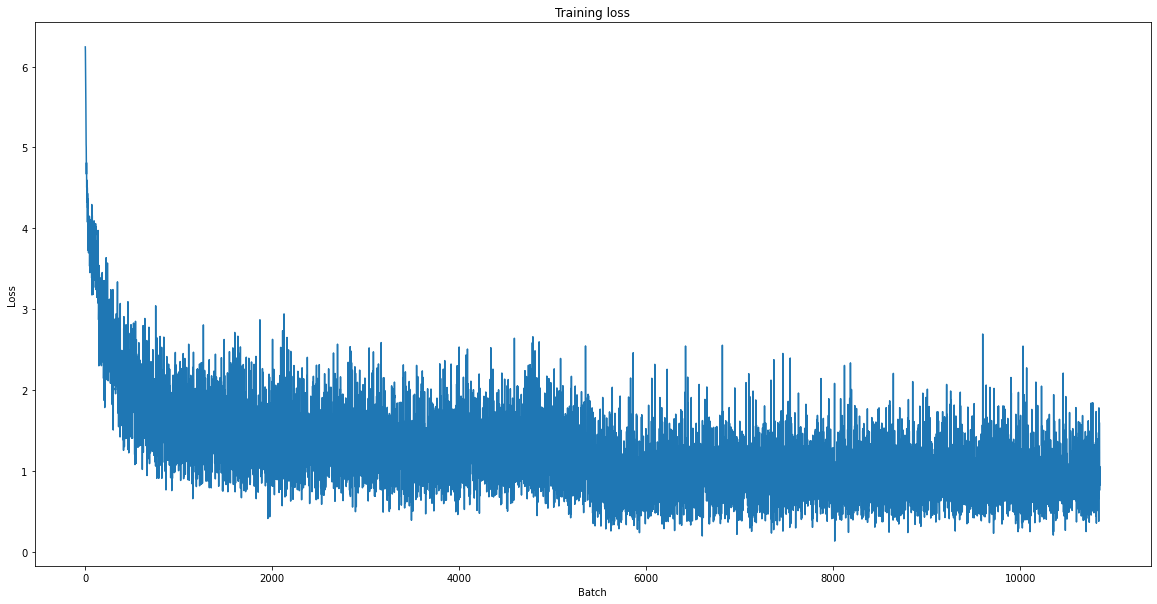

In [32]:
plt.figure(figsize=(20,10))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Evaluating the Finetuned Model after training**

In [33]:
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=True)

In [35]:
acc = []
# switch model out of training mode
model.eval()

# initialize loop for progress bar
#loop = tqdm(val_loader)
# loop through batches
for batch in val_loader:
    # we don't need to calculate gradients as we're not training
    with torch.no_grad():
        # pull batched items from loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        # make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        # getting the predictions
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        # calculate accuracy for both and append to accuracy list
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

In [37]:
# calculate average accuracy in total
acc = sum(acc)/len(acc)
print("The Test Accuracy is {}".format(acc*100))

The Test Accuracy is 65.59087583124402


###Ask Question###

In [63]:
#model
model = DistilBertForQuestionAnswering.from_pretrained('/content/drive/MyDrive/MyProject/model/checkpoint-final/')
#Tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/MyProject/model/checkpoint-final/')

In [89]:
def answer_question(question, answer_text):

    input_ids = tokenizer.encode(question, answer_text)

    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    # token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    #string of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    answer = tokens[answer_start]

    #remaining answer tokens
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [90]:
bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."


In [91]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Answer: "bidirectional encoder representations from transformers"


In [92]:
question='What is bert designed for'
answer_question(question, bert_abstract)

Answer: "bert is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers . as a result , the pre - trained bert model can be finetuned with just one additional output layer to create state - of - the - art models for a wide range of tasks , such as question answering and language inference , without substantial taskspecific architecture modifications . bert is conceptually simple and empirically powerful"
